In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import os

from nilearn import plotting

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_networks = os.path.join(path_out, 'networks/corrmats_1s')
path_parcellations = os.path.join(path_out, 'parcellations')
path_300_roi = os.path.join(path_parcellations, '300_ROI_Set/ROIs_300inVol_MNI_allInfo.txt')
df_atlas = pd.read_csv(path_300_roi, sep=' ')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=True)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_rois, n_nets = 300, 14

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


In [3]:
net_names_short = {
    'unassigned': 'UN',
    'SomatomotorDorsal': 'SOMD',
    'SomatomotorLateral': 'SOML',
    'CinguloOpercular': 'CO',
    'Auditory': 'AU',
    'DefaultMode': 'DM',
    'ParietoMedial': 'PM',
    'Visual': 'VIS',
    'FrontoParietal': 'FP',
    'Salience': 'SAL',
    'VentralAttention': 'VA',
    'DorsalAttention': 'DA',
    'MedialTemporalLobe': 'MTL',
    'Reward': 'REW'
}

df_atlas['netName'] = df_atlas['netName'].astype('category')
df_atlas['netName_short'] = pd.Series(map(lambda key: net_names_short[key], df_atlas['netName']))

labels = df_atlas['netName']

new_index = []
for label in labels.unique():
    new_index += list(labels[labels==label].index)
    
df_atlas = df_atlas.reindex(new_index)
df_atlas = df_atlas.reset_index()
df_atlas.head()

df_atlas.to_csv(
    os.path.join(path_parcellations, '300_ROI_Set/ROIs_300inVol_MNI_allInfo_reordered.txt'),
    sep=' ')

In [4]:
corr_mats_all = np.zeros((n_subjects, n_conditions, n_rois, n_rois, 9))
corr_mats_all_sym = np.zeros((n_subjects, n_conditions, n_rois, n_rois, 9))

for sub, sub_name in enumerate(meta['dim1']):
    for con, con_name in enumerate(meta['dim2']):
        # Load individual files
        fname = f'sub-{sub_name}_task-{con_name}_duration-1s_corrmats.npy'
        corr_mats = np.load(os.path.join(path_networks, fname))
        corr_mats_sym = (corr_mats + np.transpose(corr_mats, [1, 0, 2])) / 2
        
        # Reorder nodes according to large scale networks
        corr_mats = corr_mats[df_atlas['index']][:, df_atlas['index']]        
        corr_mats_sym = corr_mats_sym[df_atlas['index']][:, df_atlas['index']]
        
        # Aggregate
        corr_mats_all[sub, con] = corr_mats
        corr_mats_all_sym[sub, con] = corr_mats_sym

corr_mats_mean = np.mean(corr_mats_all, axis=0)        
corr_mats_mean_both_con = np.mean(corr_mats_mean, axis=0)
corr_mats_mean_sym = np.mean(corr_mats_all_sym, axis=0)

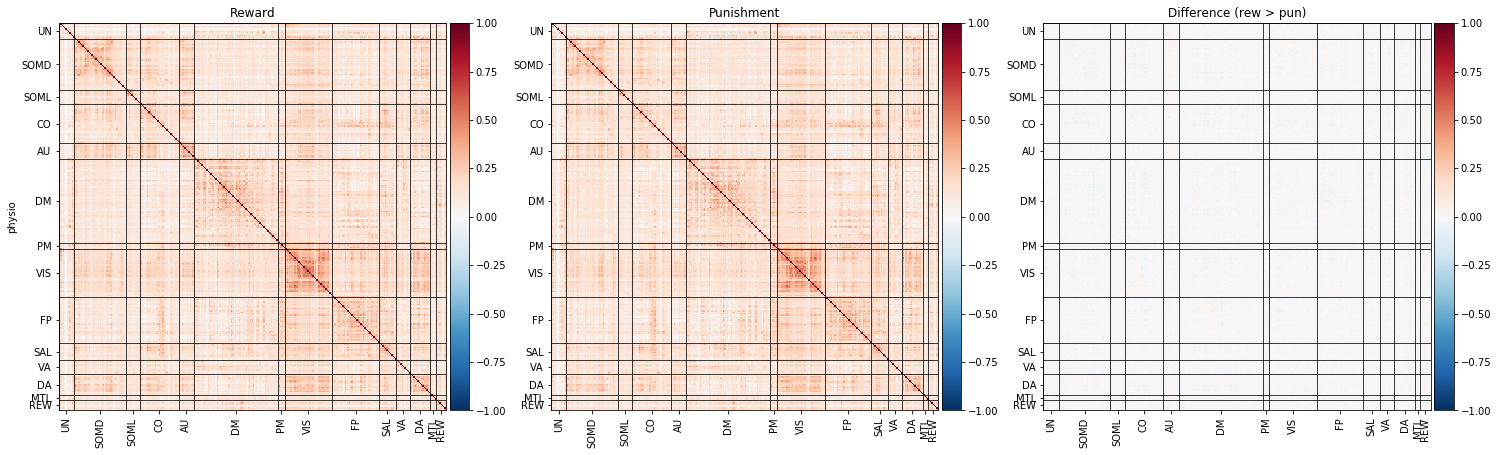

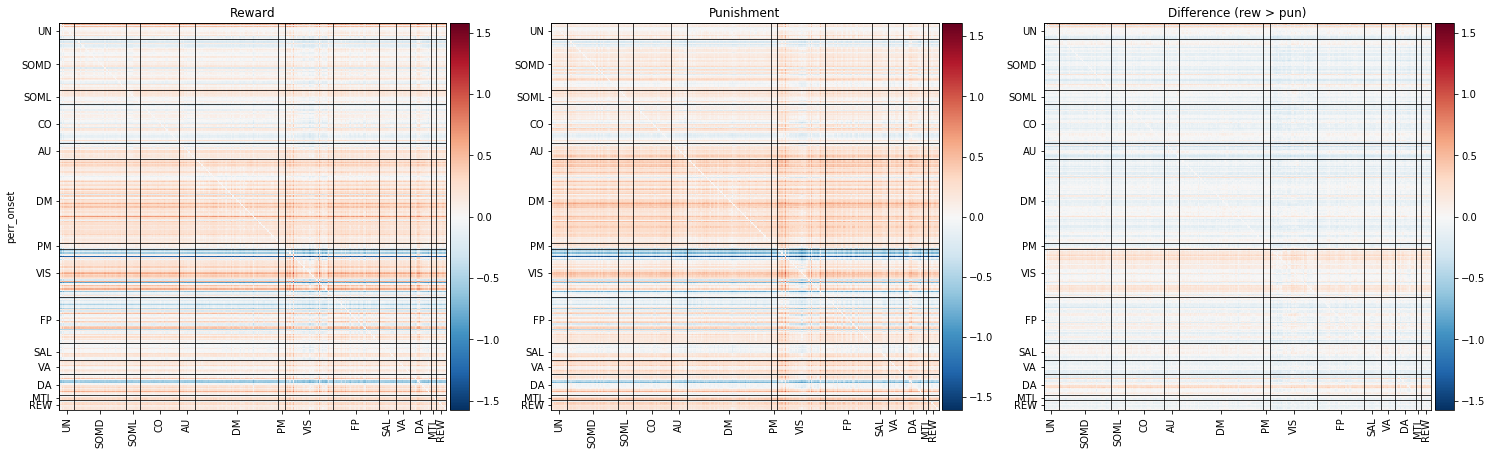

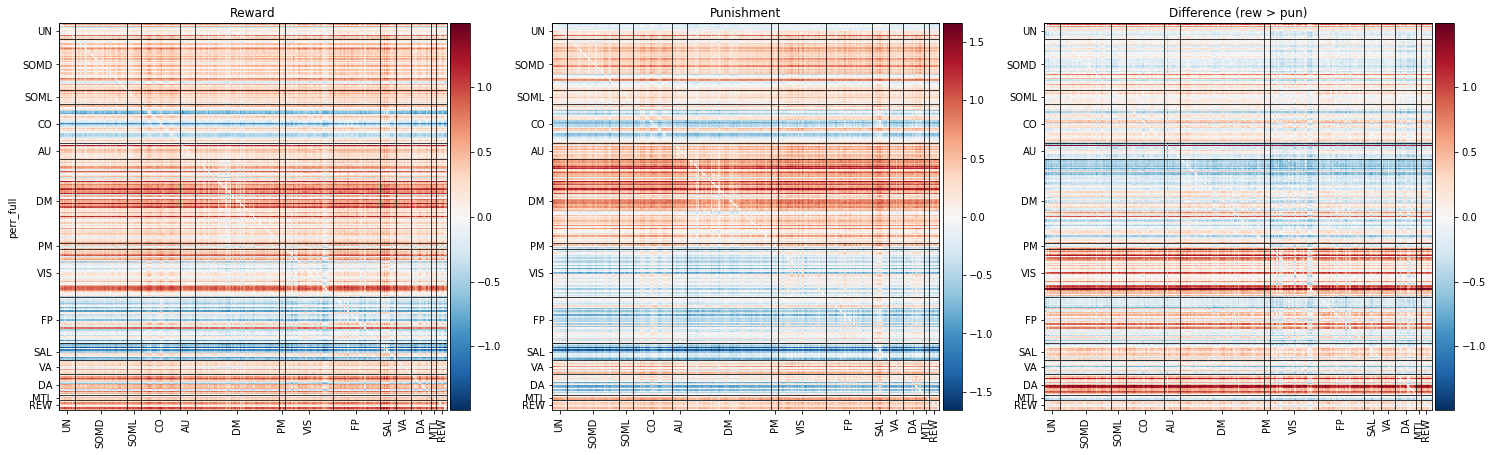

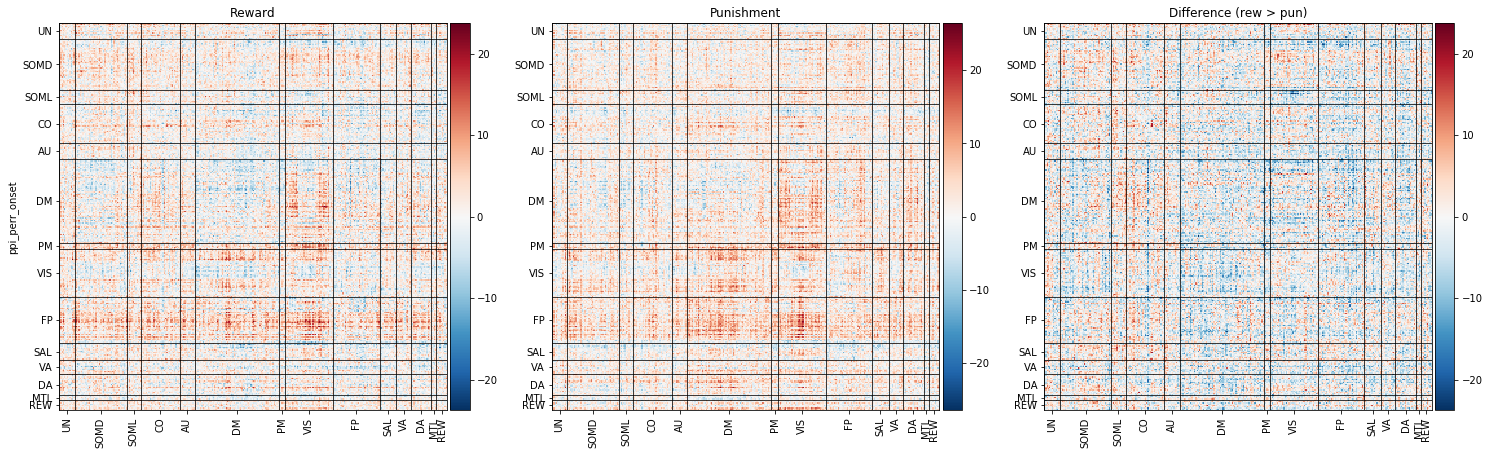

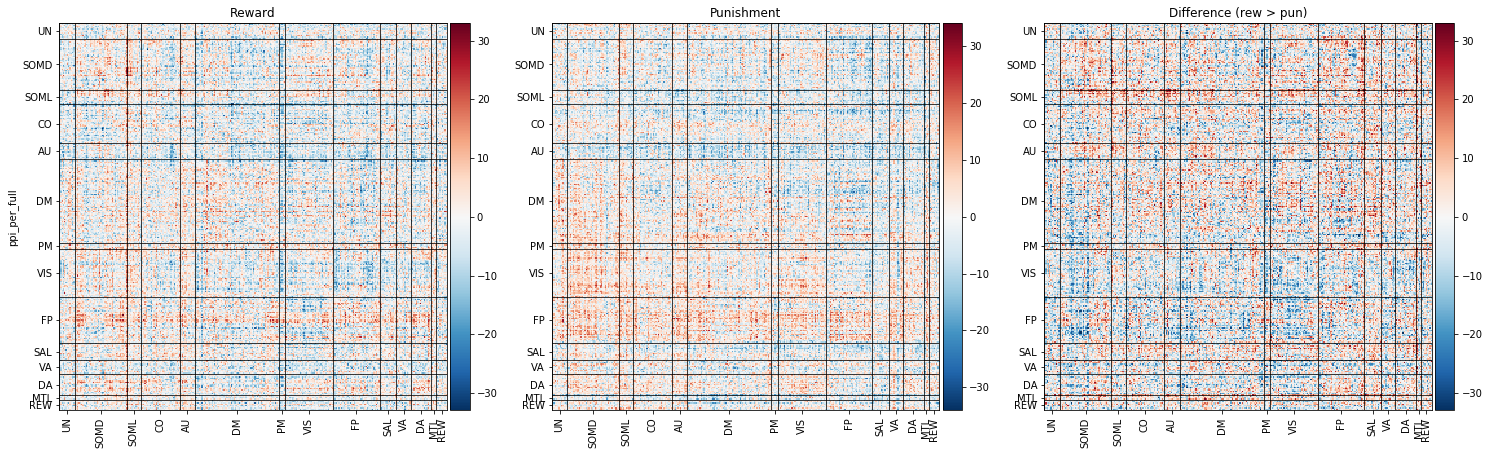

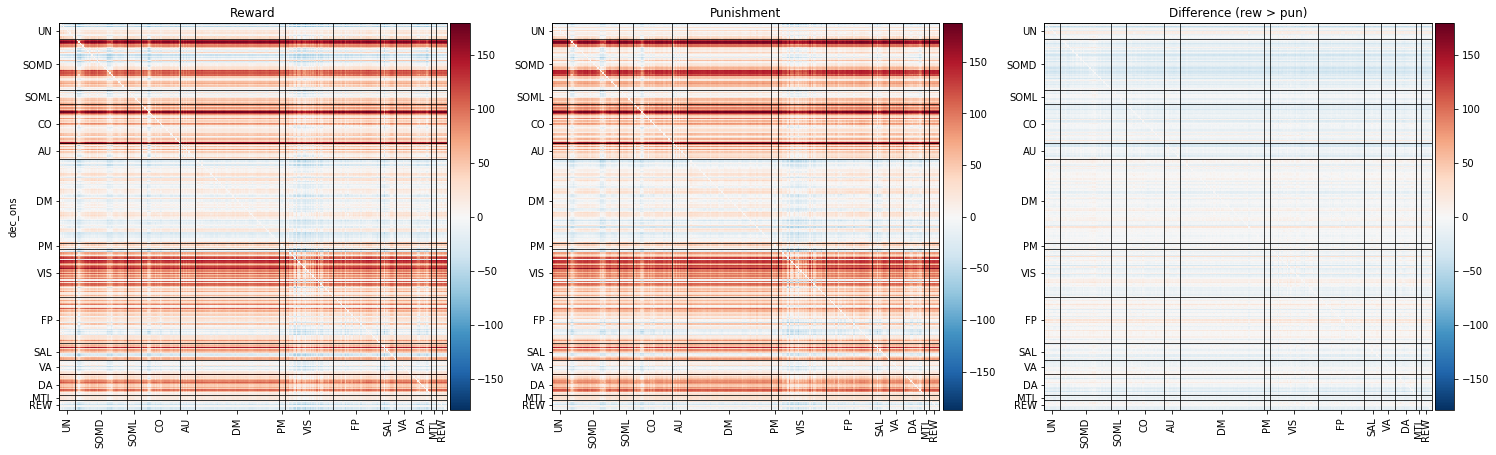

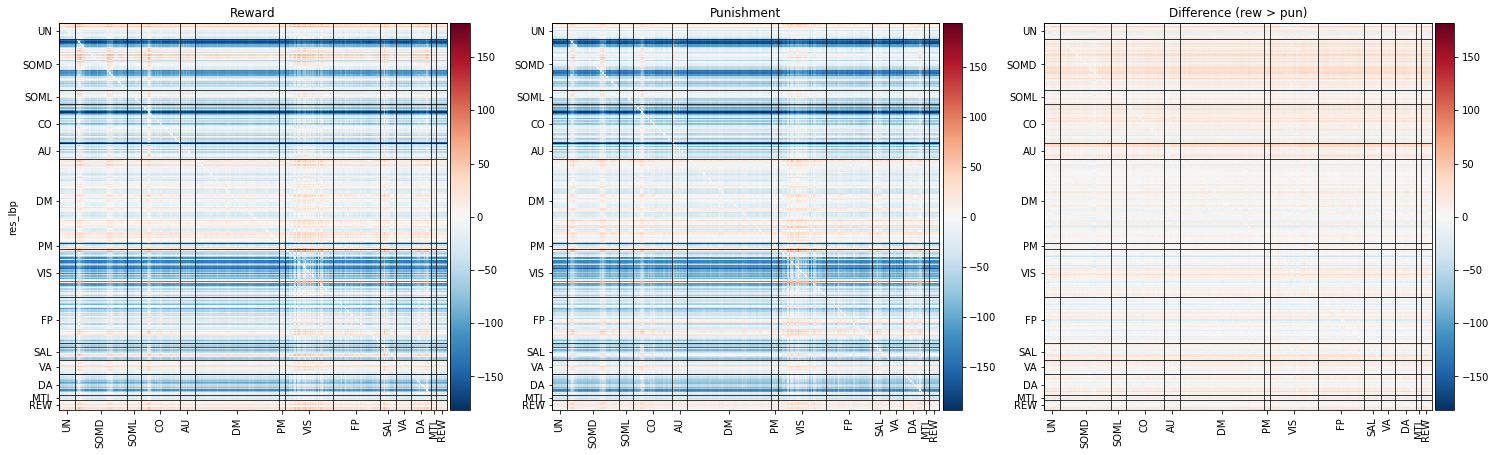

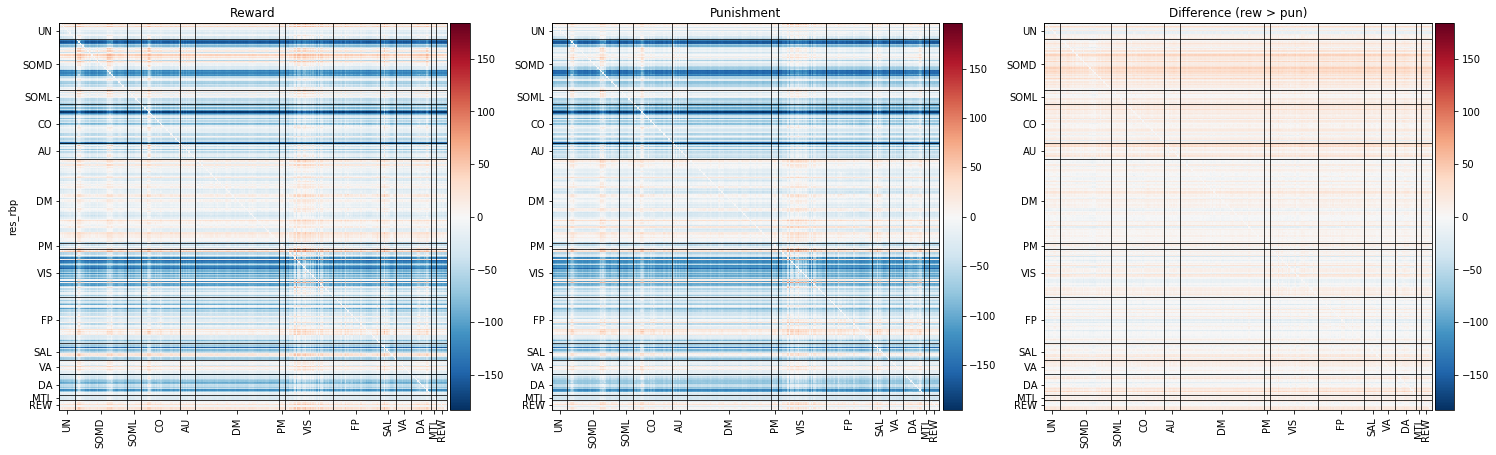

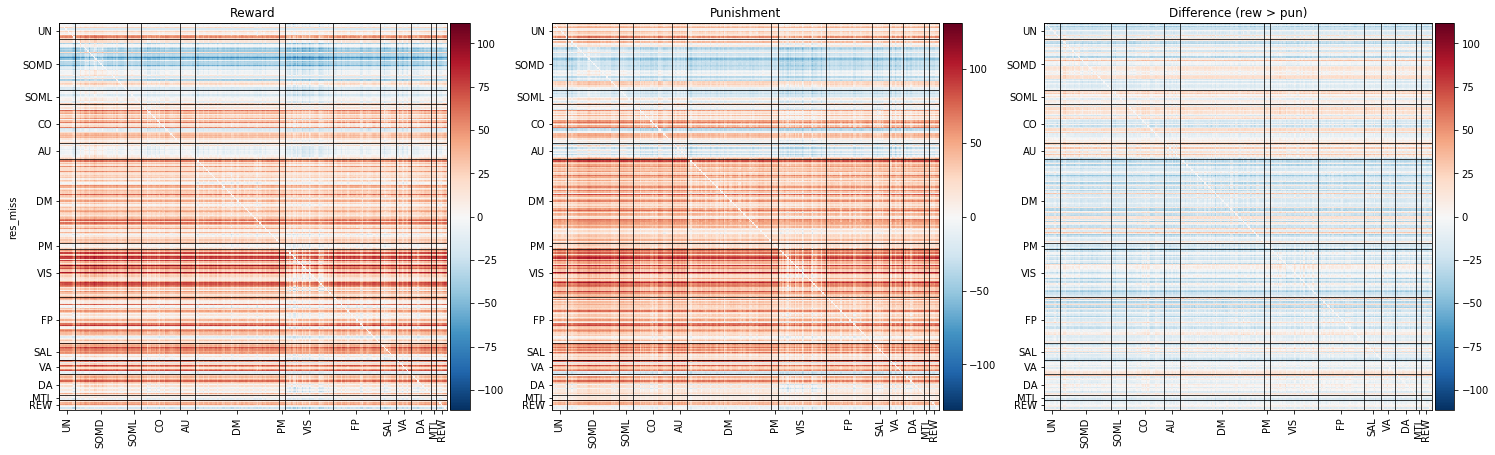

In [5]:
regressors = ['physio', 'perr_onset', 'perr_full', 'ppi_perr_onset', 'ppi_per_full',
              'dec_ons', 'res_lbp', 'res_rbp', 'res_miss']

for m, regressor in enumerate(regressors):

    fig, axs = plt.subplots(figsize=(25, 8), ncols=3, facecolor='w')

    ims = [None] * 3
    ims[0] = axs[0].imshow(corr_mats_mean[0, :, :, m], 'RdBu_r', origin='upper')
    ims[1] = axs[1].imshow(corr_mats_mean[1, :, :, m], 'RdBu_r', origin='upper')
    ims[2] = axs[2].imshow(corr_mats_mean[0, :, :, m] - corr_mats_mean[1, :, :, m], 'RdBu_r', origin='upper')

    axs[0].set_ylabel(regressor)
    axs[0].set_title('Reward')
    axs[1].set_title('Punishment')
    axs[2].set_title('Difference (rew > pun)')
    
    for im in ims[:2]:
        clim = im.get_clim()
        im.set_clim([-np.max(np.abs((im.get_clim()))), np.max(np.abs((im.get_clim())))])
    ims[-1].set_clim(ims[0].get_clim())

    for im, ax in zip(ims, axs):
        boundaries = df_atlas['netName'].cat.codes.diff() != 0
        boundaries = np.array(boundaries[boundaries].index) - .5
        boundaries = np.append(boundaries, [n_rois - .5])
        tick_positions = [(b1+b2)/2 for b1, b2 in zip(boundaries, boundaries[1:])] 

        for boundary in boundaries:
            ax.axvline(x=boundary, color='k', linewidth=1, alpha=.75)
            ax.axhline(y=boundary, color='k', linewidth=1, alpha=.75)

        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels(df_atlas['netName_short'].unique(), rotation=90)
        ax.set_yticklabels(df_atlas['netName_short'].unique())

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.show()

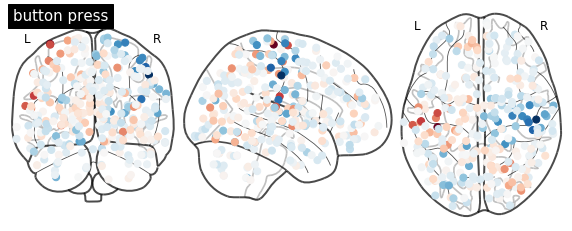

In [6]:
node_strenght = np.mean(corr_mats_mean_both_con[:, :, 7] \
                      - corr_mats_mean_both_con[:, :, 6], 
                        axis=1)
max_strenght = np.max(np.abs(node_strenght))
node_colors = [cm.RdBu_r(((s * 2 / max_strenght) + 1) / 2) for s in node_strenght]

fig, ax = plt.subplots(figsize=(10, 4))

plotting.plot_connectome(
    np.zeros((n_rois, n_rois)),
    node_coords=df_atlas.loc[:, ['x', 'y', 'z']],
    node_color=node_colors,
    axes=ax,
    title='button press'
)
plt.show()

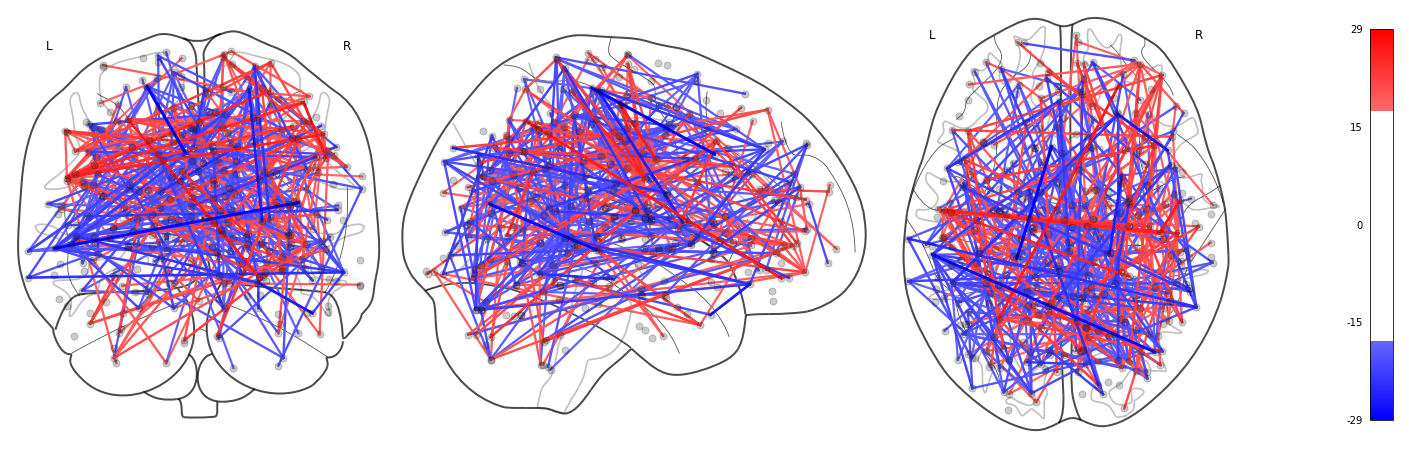

In [7]:
fig, ax = plt.subplots(figsize=(25, 8))

plotting.plot_connectome(
    corr_mats_mean_sym[0, :, :, 4],
    node_coords=df_atlas.loc[:, ['x', 'y', 'z']],
    node_color='#00000033',
    axes=ax,
    edge_threshold=17.5,
    colorbar=True
)
plt.show()

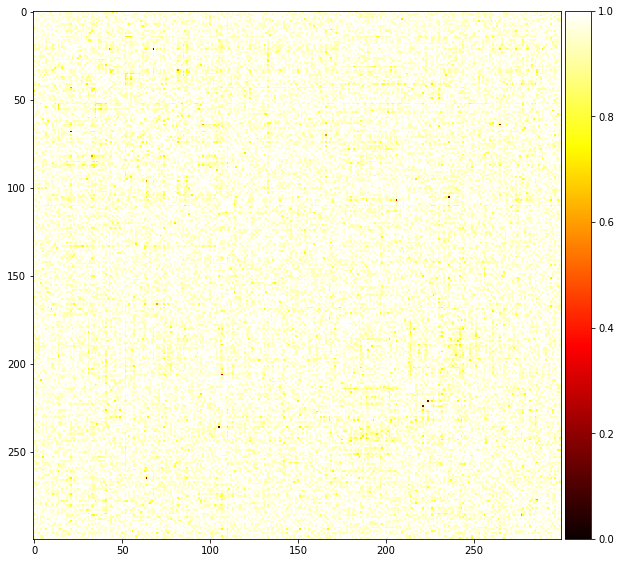

In [8]:
from statsmodels.stats.multitest import multipletests
import scipy.stats

A = corr_mats_all_sym[:, 0, :, :, 4] 

results = scipy.stats.ttest_1samp(A, popmean=0, axis=0)

pvals = results.pvalue
pvals_fdr = np.zeros(pvals.shape)
triu_indices = np.triu_indices(n_rois)

_, pvals_fdr_flatten, _, _ = multipletests(
    pvals=pvals[triu_indices],
    alpha=.05,
    method='fdr_bh'
)

pvals_fdr[triu_indices] = pvals_fdr_flatten
pvals_fdr = pvals_fdr + pvals_fdr.T

# Plotting  
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pvals_fdr, cmap='hot', clim=[0, 1])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [35]:
nets_mats_all_sym = np.zeros((n_subjects, n_conditions, n_nets, n_nets, 9))

for i, net_i in enumerate(net_names_short.values()):
    for j, net_j in enumerate(net_names_short.values()):
        net_i_indices = df_atlas[df_atlas['netName_short'] == net_i].index
        net_j_indices = df_atlas[df_atlas['netName_short'] == net_j].index
        
        nets_mats_all_sym[:, :, i, j, :] = np.mean(
            corr_mats_all_sym[:, :, net_i_indices, :, :][:, :, :, net_j_indices, :], 
            axis=(2, 3))
        
nets_mats_mean_sym = np.mean(nets_mats_all_sym, axis=0)

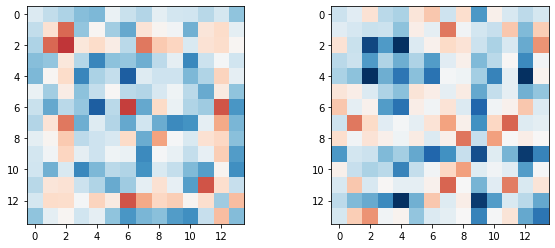

In [44]:
fig, axs = plt.subplots(figsize=(10, 4), ncols=2)

ims = [None] * 2
ims[0] = axs[0].imshow(nets_mats_mean_sym[0, :, :, 4], cmap='RdBu_r')
ims[1] = axs[1].imshow(nets_mats_mean_sym[1, :, :, 4], cmap='RdBu_r')

ims[0].set_clim([-5, 5])
ims[1].set_clim([-5, 5])

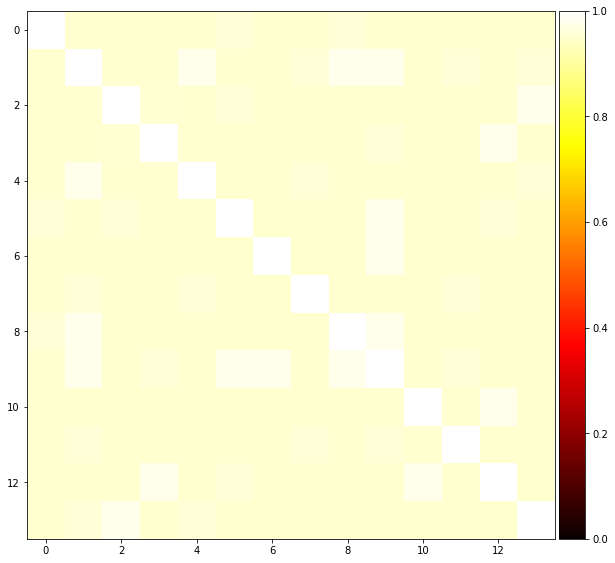

In [52]:
A = nets_mats_all_sym[:, 0, :, :, 4] 

results = scipy.stats.ttest_1samp(A, popmean=0, axis=0)

pvals = results.pvalue
pvals_fdr = np.zeros(pvals.shape)
triu_indices = np.triu_indices(n_nets)

_, pvals_fdr_flatten, _, _ = multipletests(
    pvals=pvals[triu_indices],
    alpha=.05,
    method='fdr_bh'
)

pvals_fdr[triu_indices] = pvals_fdr_flatten
pvals_fdr = pvals_fdr + pvals_fdr.T

# Plotting  
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(pvals_fdr, cmap='hot', clim=[0, 1])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

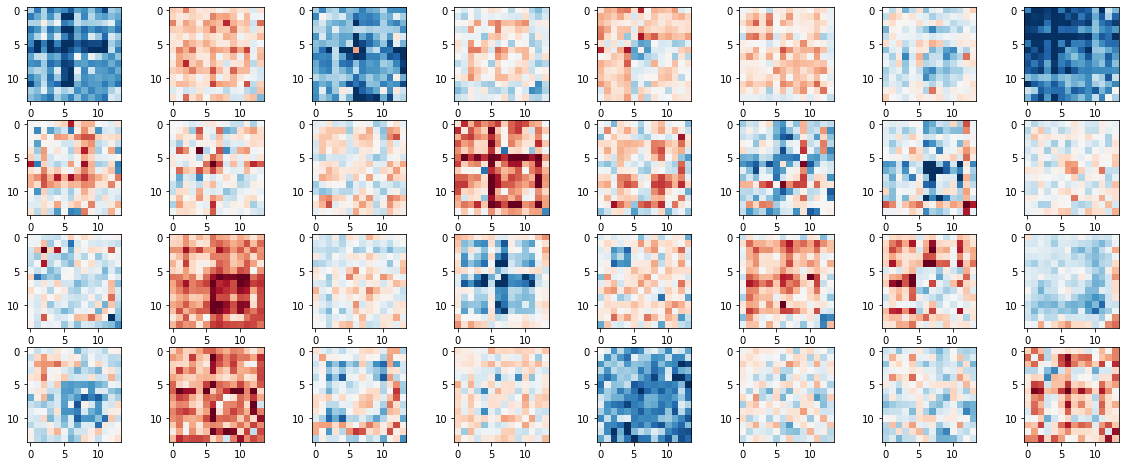

In [63]:
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))

for sub in range(n_subjects):
    im = ax[sub // 8][sub % 8].imshow(nets_mats_all_sym[sub, 0, :, :, 4], cmap='RdBu_r')
    im.set_clim(-30, 30)